In [14]:
import keras
import tensorflow as tf

from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv
import datetime
import shutil

tf.config.run_functions_eagerly(False)

In [15]:
"""Hyperparameters"""

DATASET_NAME = "flow_large"
FOLDER_NAME = "all_exp/exp6"
CHECKPOINT_PATH = "checkpoints"
LABEL = "L6"

SEED = 42

# archictecture
IMAGE_SIZE = (192, 592)
LATENT_DIM = 512
DISC_CONV_WIDTHS = [32, 64, 128, 256]
CONV_WIDTHS = [64, 128, 256, 516]

# DISC_CONV_WIDTHS = [16, 32, 64]
# CONV_WIDTHS = [32, 64, 128]

KERNELS = [3, 3, 3, 3, 3]
CONV_DEPTH = 1

# optimization
LEARNING_RATE = 5e-5
WEIGHT_DECAY = LEARNING_RATE/10
BATCH_SIZE = 4
EPOCH = 100

# callbacks
CHECKPOINT_PATH = "checkpoints"
PATIENCE = 25
START_FROM_EPOCH = 100
GENERATED_IMAGE_PATH = "generated_images"

# modes 
MODE = "training"
LOAD_WEIGTHS = True
LOAD_WEIGHT_PATH = ""
IMAGES_TO_SAVE = 1

In [16]:
"""Helper Functions"""

def load_dataset(): 
    # Load local dataset as tensorflow dataset object
    cwd = os.getcwd()
    img_dir = os.path.join(cwd, DATASET_NAME)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        img_dir, 
        validation_split = None,
        subset=None, 
        seed = SEED,
        image_size = (IMAGE_SIZE[0], IMAGE_SIZE[1]),  
        batch_size = None,
        shuffle = True,
        crop_to_aspect_ratio = True,
        pad_to_aspect_ratio = False,
    )
    return train_ds

def normalize_image(images, _):    
    # Clip pixel values to the range [-1, 1]
    images = images / 255.0
    return (images * 2.0) - 1.0

def denormalize_image(images): 
    images = (images + 1.0) / 2.0 # scale the image back to [0, 1]
    return images * 255.0

def prepare_dataset(train_ds): 
    # Use in combination with load_dataset()
    train_ds = (train_ds
                .map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE) # each dataset has the structure
                .cache()                                                   # (image, labels) when inputting to                                 # map
                .shuffle(10 * BATCH_SIZE, seed=SEED)
                .batch(BATCH_SIZE, drop_remainder=True)
                .prefetch(buffer_size=tf.data.AUTOTUNE))
    return train_ds


In [17]:
def CreateDir(folder_name):
   if not os.path.exists(folder_name):
       os.makedirs(folder_name)   

In [18]:
dataset = load_dataset()
dataset = prepare_dataset(dataset)

Found 597 files belonging to 1 classes.


2025-01-05 19:28:55.401948: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


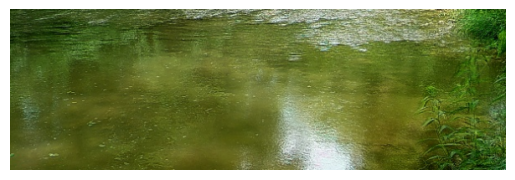

In [19]:

for x in dataset:
    plt.axis("off")
    plt.imshow((denormalize_image(x.numpy())).astype("int32")[0])
    break


In [20]:
def identity(x): 
    return x

def Build_Discriminator(): 
    discriminator_input = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(DISC_CONV_WIDTHS[0], KERNELS[0], strides=2, padding="same", kernel_initializer='he_normal')(discriminator_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    x = layers.Dropout(0.3)(x)
    for i in range(1, len(DISC_CONV_WIDTHS)-1): 
        x = layers.Conv2D(DISC_CONV_WIDTHS[i], KERNELS[i], strides=2, padding="same", kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        x = layers.Dropout(0.3)(x)
        if CONV_DEPTH > 1: 
            for _ in range(CONV_DEPTH-1): 
                x = layers.Conv2D(DISC_CONV_WIDTHS[i], KERNELS[i], strides=1, padding="same", kernel_initializer='he_normal')(x)
                x = layers.BatchNormalization()(x)
                x = layers.LeakyReLU(negative_slope=0.2)(x)
                x = layers.Dropout(0.3)(x)
    x = layers.Lambda(identity, name="final_output")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    discriminator_output = layers.Dense(1)(x)
    """SOMETIMES LEAVING THE ACTIVATION UNBOUNDED CAN YIELD EFFECTIVENESS"""
    return keras.Model(discriminator_input, discriminator_output, name="discriminator")

discriminator = Build_Discriminator()
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 192, 592, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 96, 296, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 96, 296, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 96, 296, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96, 296, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 148, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 48, 148, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 48, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 74, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 24, 74, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 24, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_output (Lambda)           │ (None, 24, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 227328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 227328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       227,329 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,473 (1.23 MB)

 Trainable params: 321,025 (1.22 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
final_output_shape = discriminator.get_layer("final_output").output.shape[1:]

print(final_output_shape)

def Build_Generator():
    latent_inputs = keras.Input(shape=(int(final_output_shape[0]/2), int(final_output_shape[1]/2), LATENT_DIM))
    x = layers.Conv2D(LATENT_DIM, KERNELS[0], strides=1, padding="same", kernel_initializer='he_normal')(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)
    for i in range(len(CONV_WIDTHS)-1, -1, -1): 
        x = layers.Conv2DTranspose(CONV_WIDTHS[i], KERNELS[i], strides=2, padding="same", kernel_initializer='he_normal')(x) 
        # x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
        # x = layers.Conv2D(CONV_WIDTHS[i], KERNELS[i], strides=1, padding="same", kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)
        if CONV_DEPTH > 0:
            for _ in range(CONV_DEPTH):
                x = layers.Conv2D(CONV_WIDTHS[i], KERNELS[i], strides=1, padding="same", kernel_initializer='he_normal')(x)
                # x = layers.Conv2DTranspose(CONV_WIDTHS[i], KERNELS[i], strides=1, padding="same", kernel_initializer='he_normal')(x)
                x = layers.BatchNormalization()(x)
                x = layers.LeakyReLU(negative_slope=0.2)(x)
    generator_outputs = layers.Conv2DTranspose(3, kernel_size=5, activation="tanh", padding="same", kernel_initializer='he_normal')(x)
    return keras.Model(latent_inputs, generator_outputs, name="generator")

generator = Build_Generator()
generator.summary()

(24, 74, 128)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 12, 37, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 12, 37, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 12, 37, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 24, 74, 516)    │     2,378,244 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 24, 74, 516)    │         2,064 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 24, 74, 516)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 74, 516)    │     2,396,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 24, 74, 516)    │         2,064 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 24, 74, 516)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 48, 148, 256)   │     1,189,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 48, 148, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 48, 148, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 148, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 48, 148, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 48, 148, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 96, 296, 128)   │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 96, 296, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 96, 296, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 96, 296, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,481,979 (36.17 MB)

 Trainable params: 9,477,099 (36.15 MB)

 Non-trainable params: 4,880 (19.06 KB)

In [22]:
# class GAN(keras.Model):
#     def __init__(self, final_output_shape):
#         super().__init__()
#         self.discriminator = Build_Discriminator()
#         self.generator = Build_Generator()
#         self.latent_dim = (int(final_output_shape[0]/2), int(final_output_shape[1]/2), LATENT_DIM)
#         self.seed_generator = keras.random.SeedGenerator(1337)

#     def compile(self, d_optimizer, g_optimizer, loss_fn):
#         super().compile()
#         self.d_optimizer = d_optimizer
#         self.g_optimizer = g_optimizer
#         self.loss_fn = loss_fn
#         self.d_loss_metric = keras.metrics.Mean(name="d_loss")
#         self.g_loss_metric = keras.metrics.Mean(name="g_loss")

#     @property
#     def metrics(self):
#         return [self.d_loss_metric, self.g_loss_metric]
    
#     def generate(self, num_of_images, generated_dir): 
#         current_date = datetime.datetime.now()
#         formatted_date = current_date.strftime("%m%d%y")

#         random_latent_vectors = keras.random.normal(
#             shape=(num_of_images, *self.latent_dim), seed=self.seed_generator
#         )
#         generated_images = self.generator(random_latent_vectors)
#         # generated_images *= 255
#         # generated_images.numpy()

#         generated_images = denormalize_image(generated_images)

#         index = 1
#         for image in generated_images: 
#             image_name = f"S0_D{formatted_date}_{formatted_date}_0_{index}_GAN_AUG_{LABEL}.JPG"
#             tf.keras.preprocessing.image.save_img(f"{generated_dir}/{image_name}", image, scale=False) 
#             index = index + 1

#     def train_step(self, real_images, n_generator_steps=5):
#         batch_size = ops.shape(real_images)[0]
        
#         # Train discriminator (once)
#         random_latent_vectors = keras.random.normal(
#             shape=(batch_size, *self.latent_dim), seed=SEED
#         )
#         generated_images = self.generator(random_latent_vectors)
#         combined_images = ops.concatenate([generated_images, real_images], axis=0)
#         labels = ops.concatenate(
#             [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
#         )
#         # Add random noise to the labels
#         labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
#         with tf.GradientTape() as tape:
#             predictions = self.discriminator(combined_images)
#             d_loss = self.loss_fn(labels, predictions)
#         grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
#         self.d_optimizer.apply_gradients(
#             zip(grads, self.discriminator.trainable_weights)
#         )
        
#         # Train generator (multiple times)
#         g_loss = 0
#         for _ in range(n_generator_steps):
#             random_latent_vectors = keras.random.normal(
#                 shape=(batch_size, *self.latent_dim), 
#                 seed=self.seed_generator
#             )
#             misleading_labels = ops.zeros((batch_size, 1))
            
#             with tf.GradientTape() as tape:
#                 predictions = self.discriminator(self.generator(random_latent_vectors))
#                 step_g_loss = self.loss_fn(misleading_labels, predictions)
#             grads = tape.gradient(step_g_loss, self.generator.trainable_weights)
#             self.g_optimizer.apply_gradients(
#                 zip(grads, self.generator.trainable_weights)
#             )
#             g_loss += step_g_loss
        
#         # Average the generator loss over all steps
#         g_loss = g_loss / n_generator_steps
        
#         # Update metrics
#         self.d_loss_metric.update_state(d_loss)
#         self.g_loss_metric.update_state(g_loss)
        
#         return {
#             "d_loss": self.d_loss_metric.result(),
#             "g_loss": self.g_loss_metric.result(),
#         }

In [23]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        final_output_shape, 
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.latent_dim = (int(final_output_shape[0]/2), int(final_output_shape[1]/2), LATENT_DIM)

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    # def generate(self, num_of_images, generated_dir): 
    #     current_date = datetime.datetime.now()
    #     formatted_date = current_date.strftime("%m%d%y")

    #     random_latent_vectors = keras.random.normal(
    #         shape=(num_of_images, *self.latent_dim), seed=self.seed_generator
    #     )
    #     generated_images = self.generator(random_latent_vectors)
    #     # generated_images *= 255
    #     # generated_images.numpy()

    #     generated_images = denormalize_image(generated_images)

    #     for i in range(generated_images[0]): 
    #         image_name = f"S0_D{formatted_date}_{formatted_date}_0_{i}_GAN_AUG_{LABEL}.JPG"
    #         tf.keras.preprocessing.image.save_img(f"{generated_dir}/{image_name}", generated_images[i], scale=False) 

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            tf.print("\nIt is real images\n")
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, *self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, *self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


In [24]:
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d_%H:%M:%S")

csv_dir = os.path.join(FOLDER_NAME, "csv_files")
CreateDir(csv_dir)

checkpoint_dir = os.path.join(FOLDER_NAME, CHECKPOINT_PATH)
CreateDir(checkpoint_dir)

generated_images_dir = os.path.join(FOLDER_NAME, "generated_images")
CreateDir(generated_images_dir)

"""MODIFY THIS PROBLEM"""
# class GANMonitor(keras.callbacks.Callback):
#     def __init__(self, latent_dim, num_img=IMAGES_TO_SAVE):
#         self.num_img = num_img
#         self.latent_dim = latent_dim
#         self.seed_generator = keras.random.SeedGenerator(42)

#     def on_epoch_end(self, epoch, logs=None):
#     # def on_train_end(self, logs=None):
#         random_latent_vectors = keras.random.normal(
#             shape=(self.num_img, *self.latent_dim), seed=self.seed_generator
#         )

#         tf.print(f"\nThis is initial noise {random_latent_vectors.shape}\n")

#         generated_dir = os.path.join(FOLDER_NAME, "plot_images")
#         CreateDir(generated_dir)

#         generated_images = self.model.generator(random_latent_vectors)
#         generated_images = denormalize_image(generated_images)

#         tf.print(f"\nThis is generated images {generated_images.shape}\n")
        
#         for i in range(generated_images[0]): 
#             image_name = f"S0_D{formatted_time}_{formatted_time}_0_{i}_GAN_AUG_{LABEL}.JPG"
#             tf.keras.preprocessing.image.save_img(f"{generated_dir}/{image_name}", generated_images[i], scale=False) 

# create a callback for logging csv files
csv_callback = keras.callbacks.CSVLogger(filename=f"{csv_dir}/log_{formatted_time}.csv", separator=",", append=True)

# Create a callback that saves the models' weights
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=f"{checkpoint_dir}/best.weights.h5",
                                                        save_best_only=True, 
                                                        save_weights_only=True, 
                                                        monitor="g_loss",
                                                        verbose=1,
                                                        mode="min")

# Create an early stopping callback
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="g_loss", 
                                                        min_delta=LEARNING_RATE/10, 
                                                        mode="min",
                                                        patience=PATIENCE, 
                                                        verbose=1, 
                                                        restore_best_weights=True, 
                                                        start_from_epoch=START_FROM_EPOCH)


In [25]:
learning_rate = LEARNING_RATE

# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [26]:
epochs = EPOCH  # In practice, use ~100 epochs

gan = WGAN(discriminator=discriminator, 
           generator=generator, 
           discriminator_extra_steps=3, 
           final_output_shape=final_output_shape)

gan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

gan.fit(
    dataset, epochs=epochs, callbacks=[#GANMonitor(num_img=IMAGES_TO_SAVE, latent_dim=(int(final_output_shape[0]/2), int(final_output_shape[1]/2), LATENT_DIM)), 
                                       csv_callback, 
                                       #early_stopping_callback
                                       ]
                            )

gan.save_weights(f"{checkpoint_dir}/last.weights.h5")

Epoch 1/100


2025-01-05 19:29:51.644369: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_30', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_17', 660 bytes spill stores, 668 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_18', 88 bytes spill stores, 88 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 92 bytes spill stores, 92 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_41', 88 bytes spill stores, 88 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_40', 660 bytes spill stores, 668 bytes spill loads
ptxas warning : Registers are spilled to local memory 

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - d_loss: -25.6025 - g_loss: 14.8051

TypeError: Cannot iterate over a scalar tensor.

In [13]:
# print(checkpoint_dir)

# gan = WGAN(final_output_shape)
# gan.load_weights(f"{checkpoint_dir}/last.weights.h5")
# gan.generate(5, generated_images_dir)

all_exp/exp4/checkpoints


2025-01-04 18:01:32.385087: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1736031692.453842   92606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736031692.473336   92606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736031692.474925   92606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736031692.476151   92606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736031692.477371   92606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736031692.478625   92606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736031692.479968   92606 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1736031692.481308   92606 gpu_t